**This notebook teaches how to:**  
set up adaptive integration schemes, set up fail operations, set up preparation and finalization instructions, and use suggested step sizes.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stammler/simframe/HEAD?labpath=examples%2F5_adaptive_schemes.ipynb)

# Adaptive Integration Schemes

For this tutorial we revisit the problem of the first tutorial.

* $\frac{\mathrm{d}Y}{\mathrm{d}x} = b\ Y$

* $Y \left( 0 \right) = A$

* $Y \left( x \right) = A\ e^{bx}$

But this time we increase the step size, such that the numeric solution is oscillating.

**Problem parameters**

In [1]:
dx =  1.75
A  =  1.
b  = -1.

**Setting up frame**

In [2]:
from simframe import Frame

sim = Frame(description="Adaptive step sizing")

**Adding field and integration variable**

In [3]:
sim.addintegrationvariable("x", 0.)
sim.addfield("Y", A)

**Setting up writer**

In [4]:
from simframe import writers

In [5]:
sim.writer = writers.namespacewriter()
sim.writer.verbosity = 0

**Setting differential equation**

We slightly modify the differential equation and add a counter that tells us how often the function got called.

In [6]:
N = 0

In [7]:
def dYdx(frame, x, Y):
    global N
    N += 1
    return b*Y

In [8]:
sim.Y.differentiator = dYdx

**Setting up the step size**

In this example we return a constant step size defined previously.

In [9]:
def fdx(frame):
    return dx

In [10]:
sim.x.updater = fdx

**Setting up snapshots**

In [11]:
import numpy as np
sim.x.snapshots = np.arange(dx, 15., dx)

**Setting up integrator**

First we simply integrate with the known 1st-order Euler scheme with a constant step size.

In [12]:
from simframe import Integrator
from simframe import Instruction
from simframe import schemes

In [13]:
sim.integrator = Integrator(sim.x)

In [14]:
sim.integrator.instructions = [Instruction(schemes.expl_1_euler, sim.Y)]

**Running the simulation**

In [15]:
sim.run()

Execution time: 0:00:00


**Reading data**

In [16]:
data = sim.writer.read.all()

We store the data in a list for later comparison.

In [17]:
dataset = []
dataset.append([data, "Euler 1st-order", N])

**Plotting**

Function returning the exact solution used for plotting

In [18]:
def f(x):
    return A*np.exp(b*x)

In [19]:
import matplotlib.pyplot as plt

def plot(dataset):
    fig, ax = plt.subplots(dpi=150)
    x = np.linspace(0, 15., 100)
    ax.plot(x, f(x), c="black", label="Exact solution")
    for i, val in enumerate(dataset):
        ax.plot(val[0].x, val[0].Y, "o", c="C"+str(i), label="{} ({} evaluations)".format(val[1], val[2]))
        ax.plot(val[0].x, val[0].Y, c="C"+str(i), lw=1)
    ax.legend(fontsize="small")
    fig.tight_layout()
    plt.show()

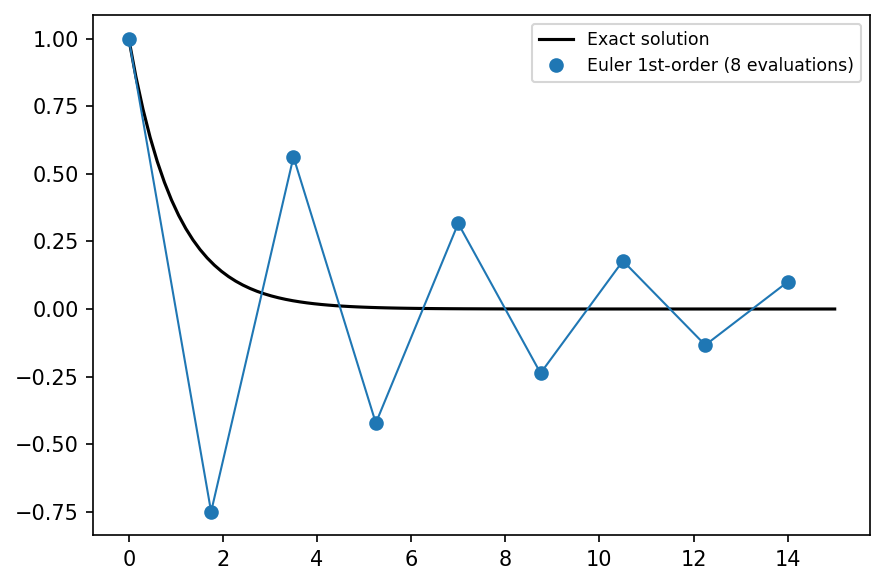

In [20]:
plot(dataset)

As you can see, the calculated solution is oscillating aroung the real solution.

## Adaptive Step Sizing Schemes

Instead of a constant step size, we now want to adjust it dynamically. If the error is too large, we decrease the step size. As an estimate for the error we compare the full Euler 1st-order step to the solution we get from performing two consecutive Euler 1st-order step with half the step size. If the relative error is larger than 10 %, we repeat the integration with a smaller step size until we are withing the error.

We therefore have to set up a custom integration scheme as was shown in the previous example. The scheme has to perform the full step and two semi steps and and needs to compare them. If the error is too large, the scheme has to return `False`. If it was successful, it has to return the change `dY` of the dependent variable `Y`.

In [21]:
def adaptive(x0, Y0, dx, *args, **kwargs):
    fullstep  = dx*Y0.derivative(x0, Y0)
    semistep1 = 0.5*fullstep
    semistep2 = 0.5*dx*Y0.derivative(x0+0.5*dx, Y0+semistep1)
    semisteps = semistep1 + semistep2
    
    relerr = np.abs((semisteps-fullstep)/(Y0+semisteps))
    
    if relerr > 0.1:
        return False
    else:
        return semisteps

**Creating scheme and modifying instruction set**

In [22]:
from simframe.integration import Scheme
adaptive = Scheme(adaptive)
sim.integrator.instructions = [Instruction(adaptive, sim.Y)]

## The fail operation

If the integration failed, because the step size was too large, i.e., the scheme returned `False`, the integrator triggers a fail operation. This operation can be used to manipulate the step size. In our case, we want to decrease the step size by a factor of 10.

Note the `global dx` to manipule `dx` persistently outside the function.

In [23]:
def failop(frame):
    global dx
    dx /= 10.

We assign this function to the fail operation of the integrator. The fail operation needs the parent `Frame` object as positional argument. If any instruction returns `False`, the fail operation will be executed and the integrator goes through the instructions again, before updating the fields.

Note: In case you have an `update` instuction in your instruction set, you have to undo it by yourself in the fail operation.

In [24]:
sim.integrator.failop = failop

## Preparation and finalization

If the integration was successful, we want to increase our step size by a factor of 5. This is done via the `finalizer` of the integrator, which is called after going through the instruction set and after updating the fields to be integrated. The equivalent that is called before going through the instructions set is `<Frame>.integrator.preparator`.

In [25]:
def finalize(frame):
    global dx
    dx *= 5.

In [26]:
sim.integrator.finalizer = finalize

**Resetting the parameters**

In [27]:
N = 0
sim.x = 0.
sim.Y = 1.
sim.writer.reset()

Before running the simulation we save the inital step size for later use.

In [28]:
import copy
dx_ini = dx

**Running the simulation**

In [29]:
sim.run()

Execution time: 0:00:00


**Reading data and plotting**

In [30]:
data_adaptive = sim.writer.read.all()

In [31]:
dataset.append([data_adaptive, "Adaptive Euler 1st-order", N])

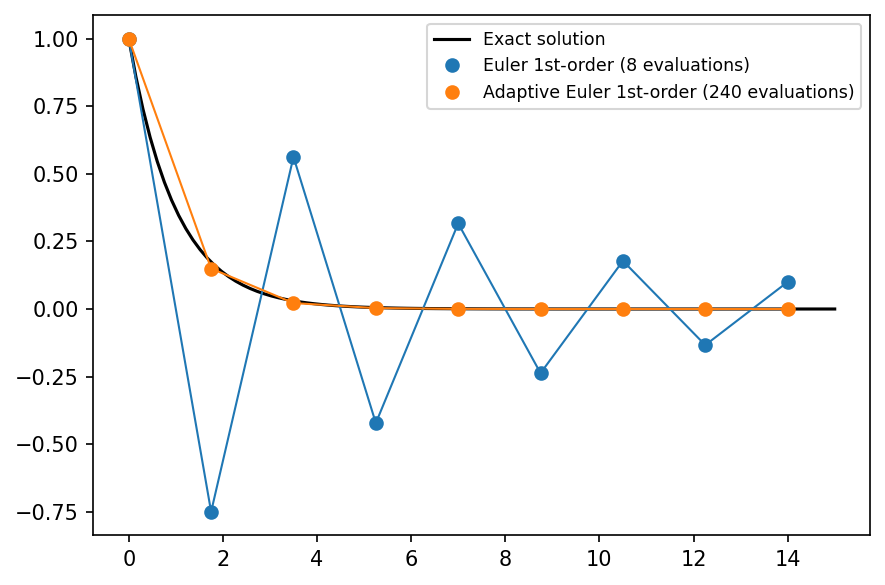

In [32]:
plot(dataset)

**Embedded methods**

Another technique for estimating the error is to perform a higher order method for the full step instead of the same method for two semistep as done before. In some cases the higher order method is utilizing the result of the lower order method, saving evaluations. These methods are called embedded methods.

`simframe` comes with a few embedded methods. In this example we use the embedded Bogacki-Shampine method.

In [33]:
sim.integrator.instructions = [Instruction(schemes.expl_3_bogacki_shampine_adptv, sim.Y)]

## Suggested step sizes

The embedded methods included in `simframe` provide an estimate for the new step size depending on the truncation error. This estimate is saved in the integration variable in `<IntVar>.suggested`. We have to modify the step size function to utilize this estimate.

In [34]:
def fdx(sim):
    return sim.x.suggested

In [35]:
sim.x.updater = fdx

And we have to give an initial suggestion for the step size. We'll use the initial value as before.

In [36]:
sim.x.suggest(dx_ini)

**Unsetting fail operation and finalization**

The fail operation and finalization operations are not needed anymore and have to be unset.

In [37]:
sim.integrator.failop = None
sim.integrator.finalizer = None

**Resetting the parameters and running the simulation**

In [38]:
N = 0
sim.x = 0.
sim.Y = 1.
sim.writer.reset()

In [39]:
sim.run()

Execution time: 0:00:00


**Reading data and plotting**

In [40]:
data_bogackishampine = sim.writer.read.all()

In [41]:
dataset.append([data_bogackishampine, "Adaptive Bogacki-Sahmpine 3rd-order", N])

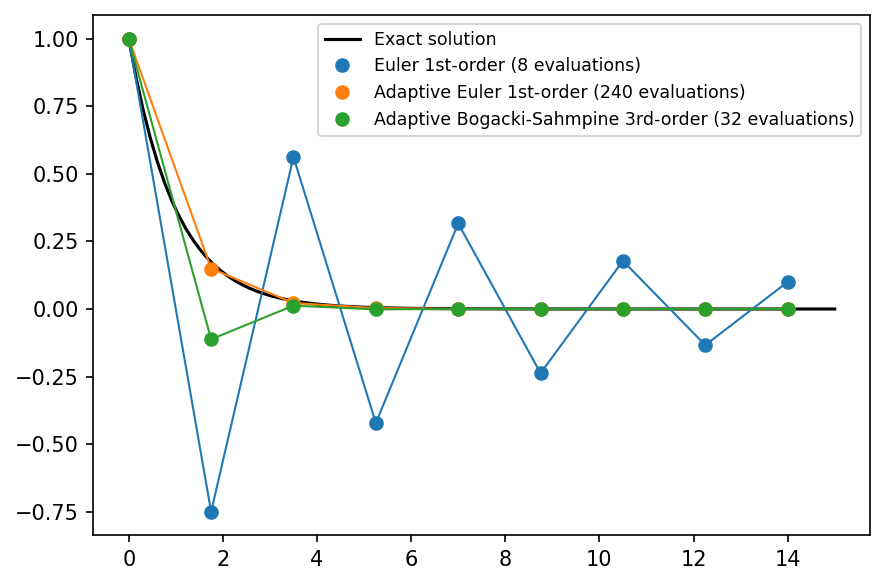

In [42]:
plot(dataset)

As you can see the Bogacki-Shampine method needs 32 eveluations of the derivative in this setup. That's only about half of the amount of the adaptive Euler method and it's significantly more accurate.

Change the stepsize to `dx = 2.25` and run the notebook again. For this step size the Euler 1st-order method is unstable.

## Passing keyword arguments to integration scheme

It is also possible to pass key word arguments to the integrator to control its behaviour. We could for example increase the accuracy by changing the desired relative error. This is done by passing a controller dictionary to the instruction.

In [43]:
sim.integrator.instructions = [Instruction(schemes.expl_3_bogacki_shampine_adptv, sim.Y, controller={"eps": 0.01})]

Here we want to have maximum relative error of $1\,\%$. Default is $10\,\%$.

**Resetting the parameters and running the simulation**

Note the `reset=True` keyword when resetting the suggested step size. Suggesting step sizes takes the minimum of the suggested and the current value, which is still set from the earlier integration. We therefore have to reset the current value with the keyword.

In [44]:
N = 0
sim.x = 0.
sim.x.suggest(dx_ini, reset=True)
sim.Y = 1.
sim.Y._buffer = None
sim.writer.reset()

In [45]:
sim.run()

Execution time: 0:00:00


**Reading and plotting data**

In [46]:
data_bogackishampine_accurate = sim.writer.read.all()

In [47]:
dataset.append([data_bogackishampine_accurate, "Adaptive Bogacki-Shampine 3rd-order ($\epsilon=0.01$)", N])

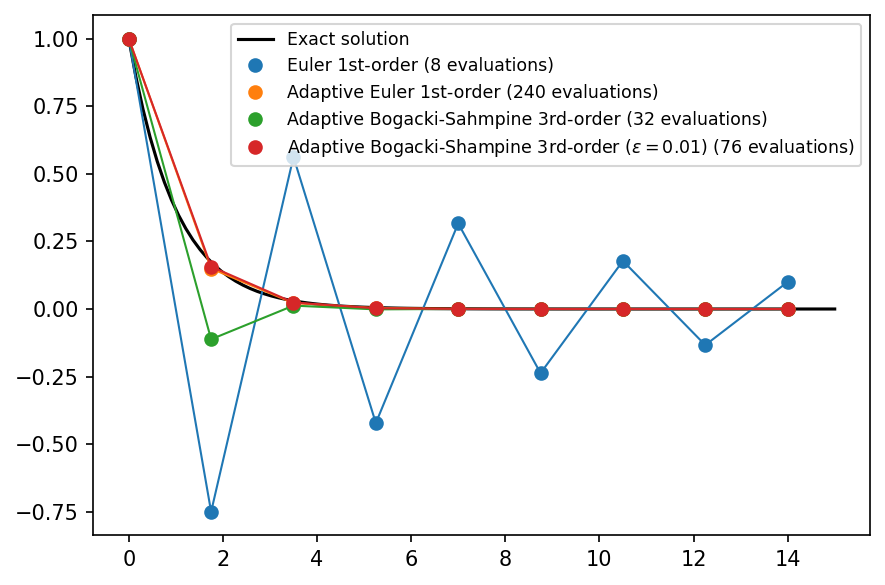

In [48]:
plot(dataset)

With this settings it takes slightly longer to approach the analytical solution, but the overshooting in the beginning is prevented.